# 0. Imports

## 0.1. Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
import scikitplot as skplt
import numpy as np
import pickle
from flask import Flask, request
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

from boruta import BorutaPy

## 0.2. Helper Functions

In [3]:
# Save intermediate dataset
def save_interim(dataframe, file_name):
   dataframe.to_csv('../data/interim/'+file_name+'.zip', index=False, compression= 'zip')

# Load intermediate dataset
def load_interim(file_name):
   return pd.read_csv('../data/interim/'+file_name, compression='zip')

## 0.2. Loading Dataset

In [4]:
df_raw = pd.read_csv('/home/ezequiel/Documentos/Comunidade_DS/health_insurance_cross_sell/data/raw/train.csv')
#df1 = df_raw.copy()

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.3. Spliting Dataset into trainning and validation

In [6]:
seed = 42

In [7]:
df1, df_validation = train_test_split(df_raw, test_size=0.2, stratify=df_raw['Response'], random_state=seed)

In [8]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
274710,274711,Male,22,1,40.0,0,< 1 Year,Yes,25455.0,152.0,203,0
216539,216540,Female,26,1,8.0,1,< 1 Year,No,38393.0,26.0,45,0
78983,78984,Female,32,1,28.0,0,< 1 Year,Yes,32118.0,122.0,35,1
218368,218369,Male,32,1,37.0,0,< 1 Year,Yes,37711.0,152.0,215,0
307215,307216,Female,24,1,28.0,0,< 1 Year,Yes,48706.0,156.0,222,0


In [9]:
save_interim(df_validation, 'df_validation.csv')

In [10]:
df1.columns = df1.columns.str.lower()

In [11]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [12]:
save_interim(df1, 'df1.csv')

# 1. Data Description

Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

Currency: Idian Rupee (Rs)

## 1.1. Data Dimension

In [13]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 304887
Number of columns: 12


## 1.2. Data Types

In [14]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [15]:
# Changing driving_license, previously_insured, vehicle_damage and response to a less cost memory data type, for example, int32
df1['driving_license'] = df1['driving_license'].astype('int8')
df1['previously_insured'] = df1['previously_insured'].astype('int8')
df1['response'] = df1['response'].astype('int8')

In [16]:
save_interim(df1, 'df1.csv')

## 1.3. Check NA

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304887 entries, 274710 to 221791
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   gender                304887 non-null  object 
 2   age                   304887 non-null  int64  
 3   driving_license       304887 non-null  int8   
 4   region_code           304887 non-null  float64
 5   previously_insured    304887 non-null  int8   
 6   vehicle_age           304887 non-null  object 
 7   vehicle_damage        304887 non-null  object 
 8   annual_premium        304887 non-null  float64
 9   policy_sales_channel  304887 non-null  float64
 10  vintage               304887 non-null  int64  
 11  response              304887 non-null  int8   
dtypes: float64(3), int64(3), int8(3), object(3)
memory usage: 24.1+ MB


## 1.4. Data Description

### 1.4.1. Categorical variables

In [18]:
cat_attributes = df1.select_dtypes(include='object')
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

In [19]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164780,160195,153959


In [20]:
cat_attributes.apply(pd.Series.value_counts)

,gender,vehicle_age,vehicle_damage
1-2 Year,NaN,160195.0,NaN
< 1 Year,NaN,131852.0,NaN
> 2 Years,NaN,12840.0,NaN
Female,140107.0,NaN,NaN
Male,164780.0,NaN,NaN
No,NaN,NaN,150928.0
Yes,NaN,NaN,153959.0


**Summary**
- Male is the top gender
- Top vehicle age is between 1 and 2 years
- Most of cars have already had damaged

### 1.4.2. Numerical variables

In [21]:
num_attributes = df1.select_dtypes(exclude='object')
df_describe = num_attributes.describe().T
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe['skewness'] = num_attributes.skew()

In [22]:
df_describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
id,304887.0,190738.657112,110004.367239,1.0,95504.5,190886.0,285863.5,381109.0,-1.199436,-0.001457
age,304887.0,38.826897,15.515299,20.0,25.0,36.0,49.0,85.0,-0.568526,0.671710
driving_license,304887.0,0.997855,0.046265,0.0,1.0,1.0,1.0,1.0,461.197806,-21.521960
region_code,304887.0,26.396239,13.228749,0.0,15.0,28.0,35.0,52.0,-0.866961,-0.115538
previously_insured,304887.0,0.458127,0.498244,0.0,0.0,0.0,1.0,1.0,-1.971761,0.168083
annual_premium,304887.0,30591.308311,17239.285689,2630.0,24403.0,31697.0,39443.0,540165.0,32.191697,1.721299
policy_sales_channel,304887.0,112.053859,54.189288,1.0,29.0,134.0,152.0,163.0,-0.969360,-0.900677
vintage,304887.0,154.392214,83.670312,10.0,82.0,154.0,227.0,299.0,-1.200642,0.002134
response,304887.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298797,2.301907


**Summary**
- Some numerical variables are representing cattegorical variables:
    - driving license
    - previously insured
    - response
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage
    - region code?
    - policy sales channel?

<Axes: xlabel='vintage', ylabel='Count'>

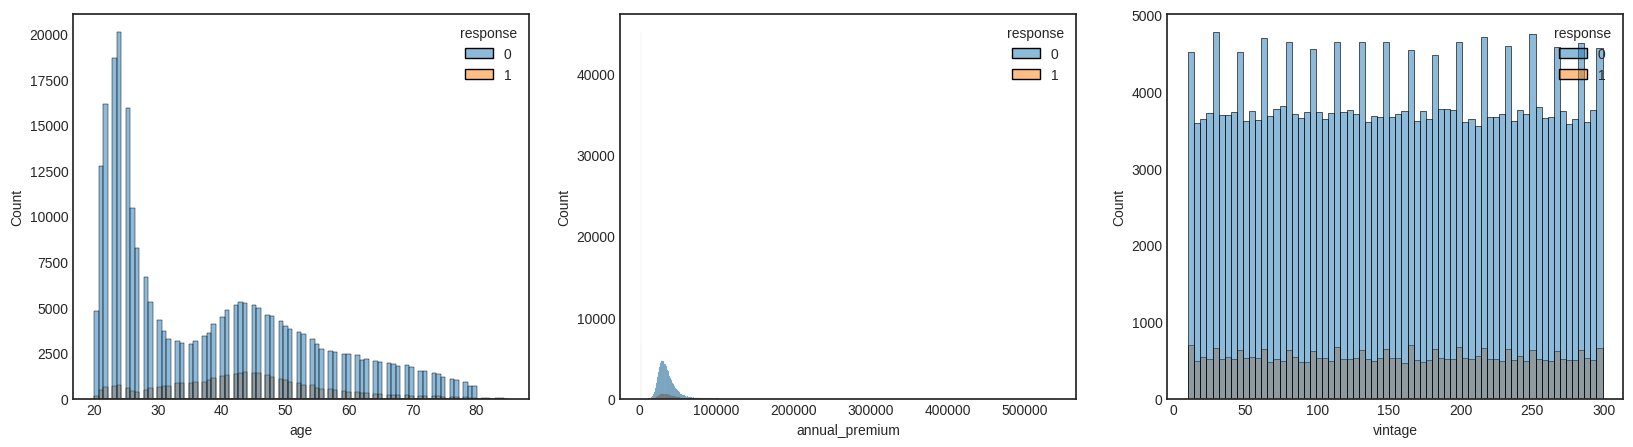

In [23]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.histplot(data=df1, x=df1['age'], hue=df1['response'], ax=ax[0])
sns.histplot(data=df1, x=df1['annual_premium'], hue=df1['response'], ax=ax[1])
sns.histplot(data=df1, x=df1['vintage'], hue=df1['response'], ax=ax[2])

In [24]:
save_interim(df1, 'df2.csv')

### 1.4.3. Target variable

In [25]:
df1[['response']].value_counts(normalize=True)

response
0           0.877437
1           0.122563
Name: proportion, dtype: float64

<Axes: xlabel='response', ylabel='count'>

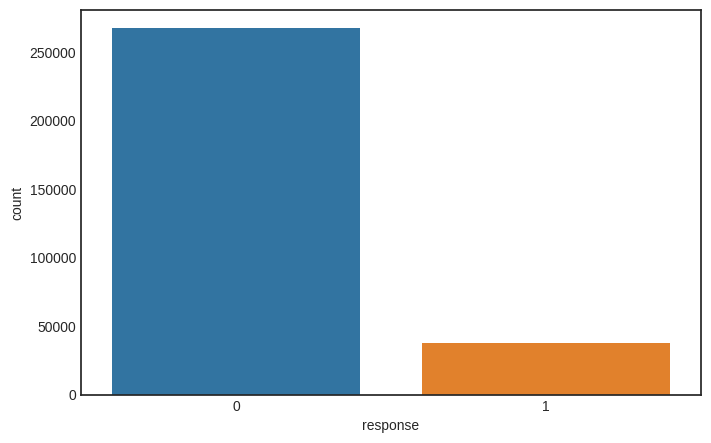

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x=df1['response'])

**Summary**
- Response is **unbalanced**
    * 87,74% wouldn't be interested
    * 12,26% would be interested

# 2. Feature Engeneering

In [27]:
df1['vehicle_age'] = df1['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else
                                              'below_1_year')

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [28]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40.0,0,below_1_year,1,25455.0,152.0,203,0
216539,216540,Female,26,1,8.0,1,below_1_year,0,38393.0,26.0,45,0
78983,78984,Female,32,1,28.0,0,below_1_year,1,32118.0,122.0,35,1
218368,218369,Male,32,1,37.0,0,below_1_year,1,37711.0,152.0,215,0
307215,307216,Female,24,1,28.0,0,below_1_year,1,48706.0,156.0,222,0


In [29]:
save_interim(df1, 'df3.csv')

# 3. Data Filtering

# 4. Exploratory Data Analysis (EDA)

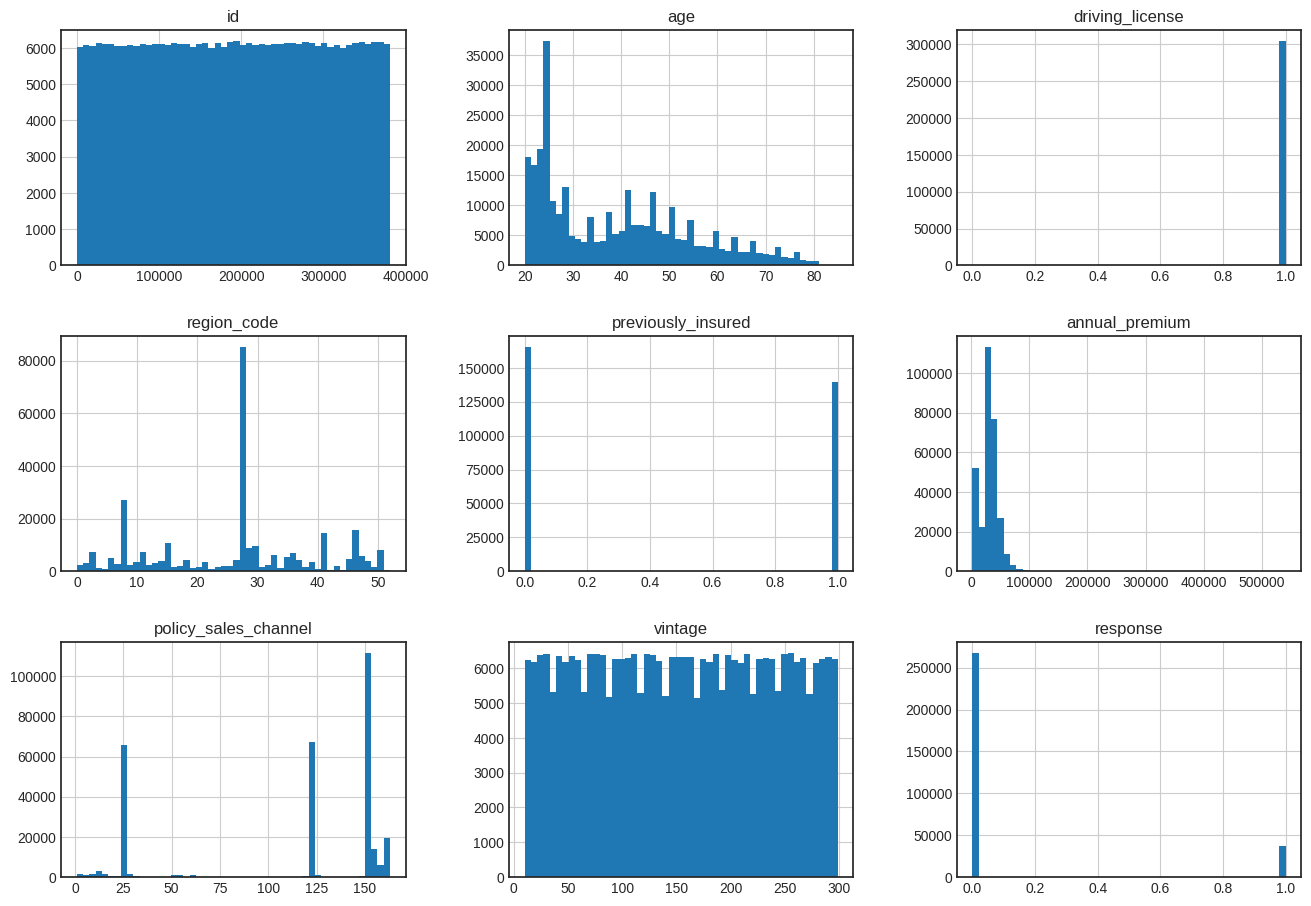

In [30]:
num_attributes.hist(bins=50, figsize=(16,11));

/home/ezequiel/.pyenv/versions/HICS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


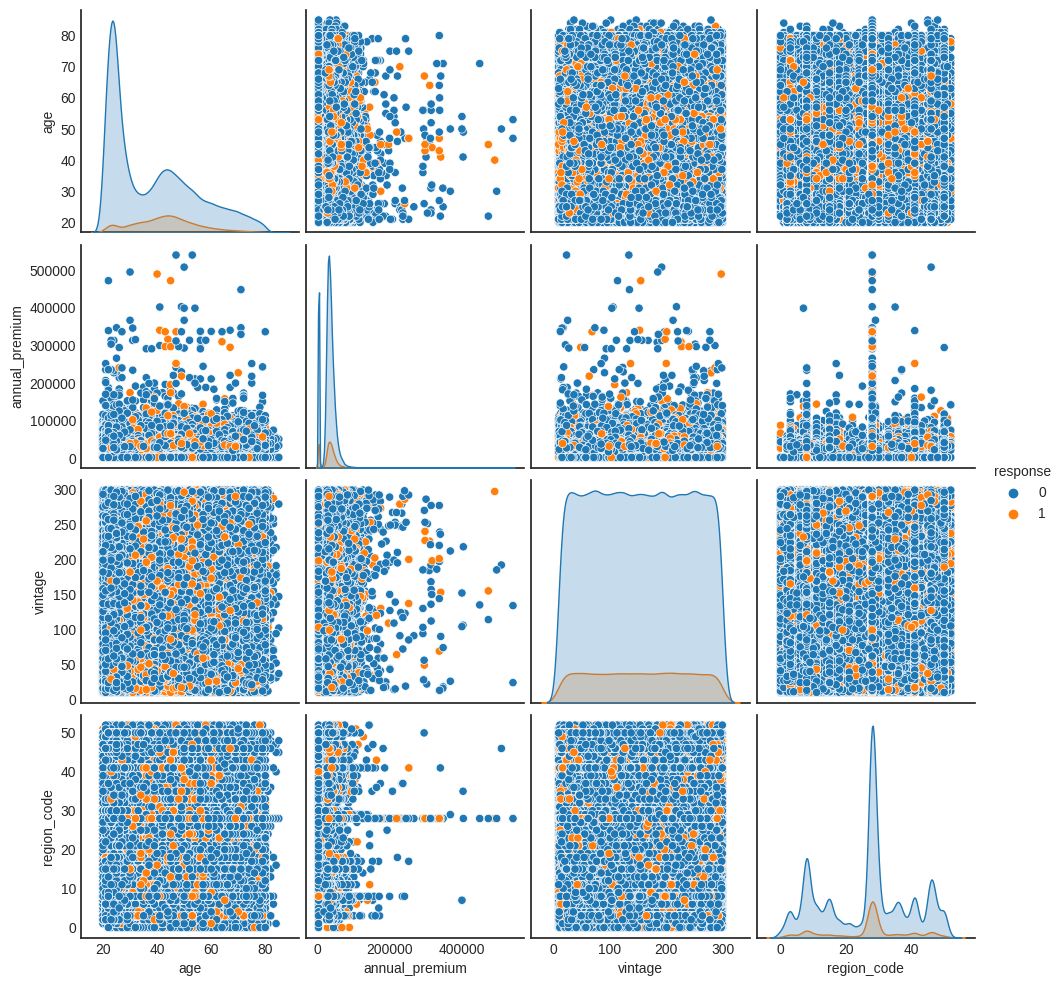

In [31]:
sns.pairplot(data=df1, vars=['age', 'annual_premium', 'vintage', 'region_code'], hue='response')
plt.show()

**Summary**
- Individuals with lower ages would not be interested in health insurace
- There is no clear correlation

## 4.1. Hypothesis

Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

Currency: Idian Rupee (Rs)

- **H1**: Individuals with more than 30 years would be interested in health insurance.
- **H2**: Women would be more interested in having health insurance.
- **H3**: Individuals who already have driving license and got the vehicle damage in the past would be more interested in health insurance.
- **H4**: Individuals who already have vehicle insurance (previously insured) would be more interested in health insurance.
- **H5**: Individuals who got the vehicle damaged and are previously insuded would be more interested in health insurance.
- **H6**: Individuals who own vehicle with less than one year would be more interested in health insurance.
- **H7**: Individuals who own vehicle with more than two year would be more interested in health insurance.

## 4.2. Univariate Analisys

#### 4.1.1. Age

<Axes: xlabel='age', ylabel='Count'>

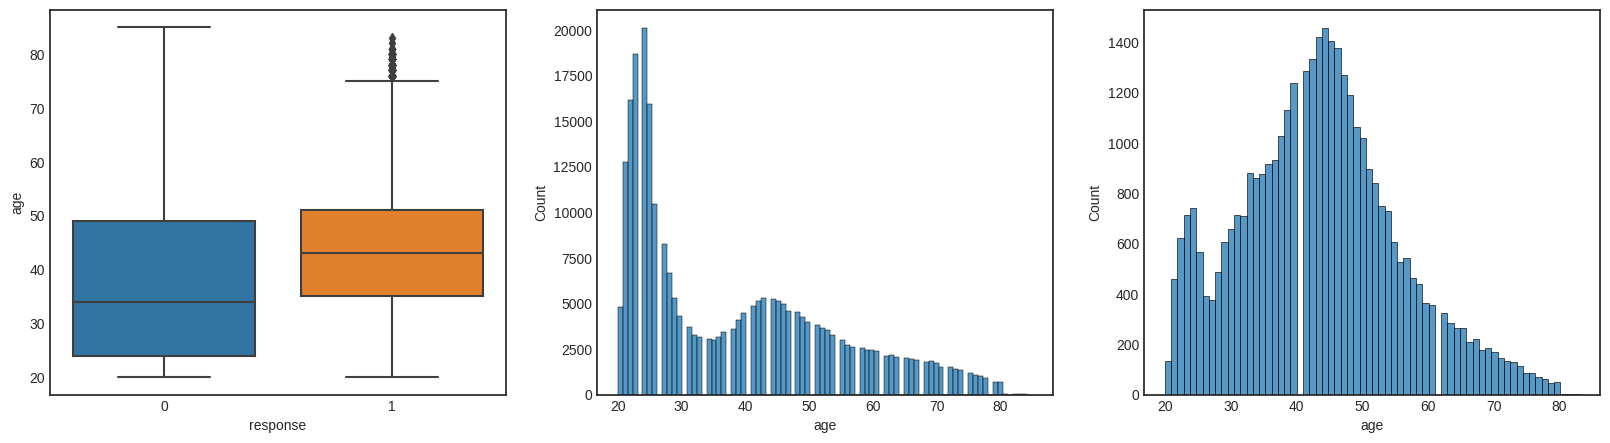

In [32]:
# age
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='age', data=df1)
sns.histplot(df1.loc[df1['response'] == 0, 'age'], ax=ax[1])
sns.histplot(df1.loc[df1['response'] == 1, 'age'], ax=ax[2])
#ax[1].hist(df1.loc[df1['response'] == 0, 'age'])

#### **H1**: Individuals with more than 30 years would be interested in health insurance.

In [90]:
aux0 = pd.DataFrame(df1.query('age > 20')['response'].value_counts(normalize=True)).reset_index().rename(columns={'proportion': 'age > 20'})
aux0['age > 30'] = pd.DataFrame(df1.query('age > 30')['response'].value_counts(normalize=True)).reset_index()[['proportion']]
aux0['age > 40'] = pd.DataFrame(df1.query('age > 40')['response'].value_counts(normalize=True)).reset_index()[['proportion']]
aux0['age > 50'] = pd.DataFrame(df1.query('age > 50')['response'].value_counts(normalize=True)).reset_index()[['proportion']]
aux0['age > 60'] = pd.DataFrame(df1.query('age > 60')['response'].value_counts(normalize=True)).reset_index()[['proportion']]

In [91]:
aux0

,response,age > 20,age > 30,age > 40,age > 50,age > 60
0,0,0.87586,0.820121,0.830271,0.86554,0.902777
1,1,0.12414,0.179879,0.169729,0.13446,0.097223


<Axes: xlabel='response', ylabel='count'>

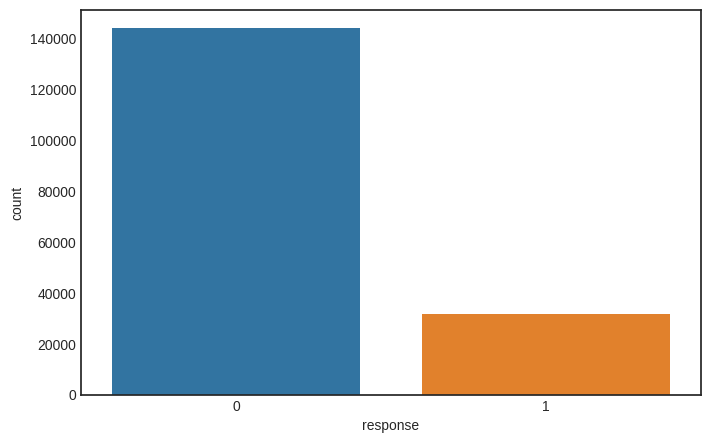

In [68]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1.query('age > 30'), x=df1.query('age > 30')['response'])

**H1** is FALSE. Only about 18% of people older than 30 years are interested in health insurance
- OBS.: This proportion decreases when the age is increased.

### 4.1.2. Annual Premium

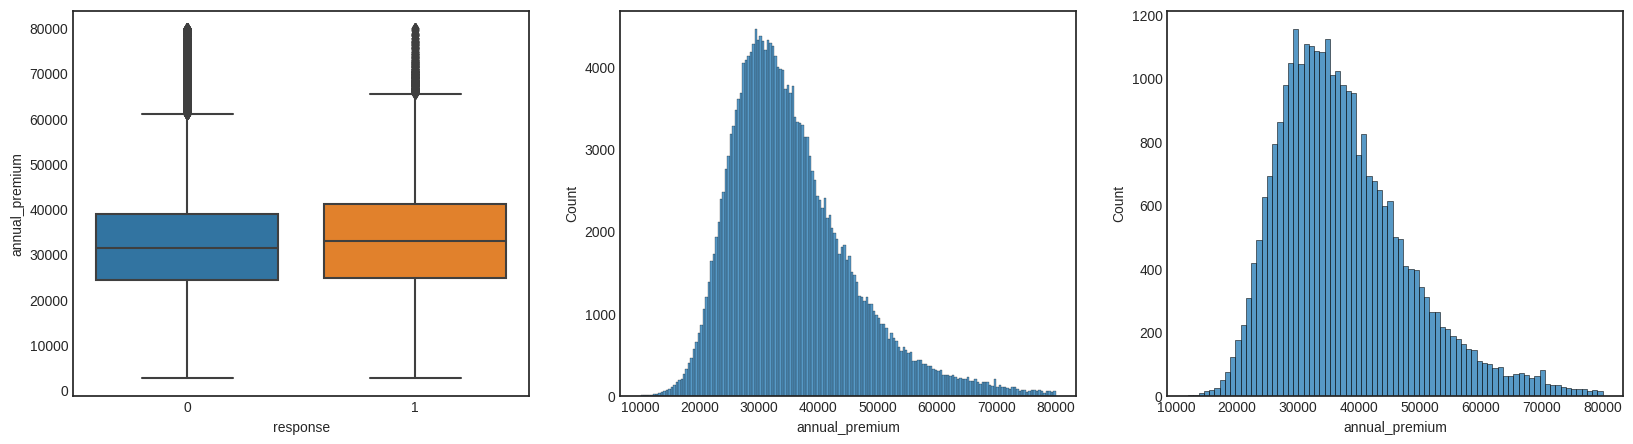

In [34]:
# annual_premium
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='annual_premium', data=df1.loc[df1['annual_premium'] < 80000])
sns.histplot(df1.loc[(df1['response'] == 0) & (df1['annual_premium'] > 10000) & (df1['annual_premium'] < 80000), 'annual_premium'], ax=ax[1])
sns.histplot(df1.loc[(df1['response'] == 1) & (df1['annual_premium'] > 10000) & (df1['annual_premium'] < 80000), 'annual_premium'], ax=ax[2]);

# Aparentemente não há distinção entre as classes de response quando se compara annual_premium

### 4.1.3. Driving License

In [35]:
# driving_license
df1[['driving_license', 'response']].value_counts()

driving_license  response
1                0           266899
                 1            37334
0                0              620
                 1               34
Name: count, dtype: int64

### 4.1.4. Region Code

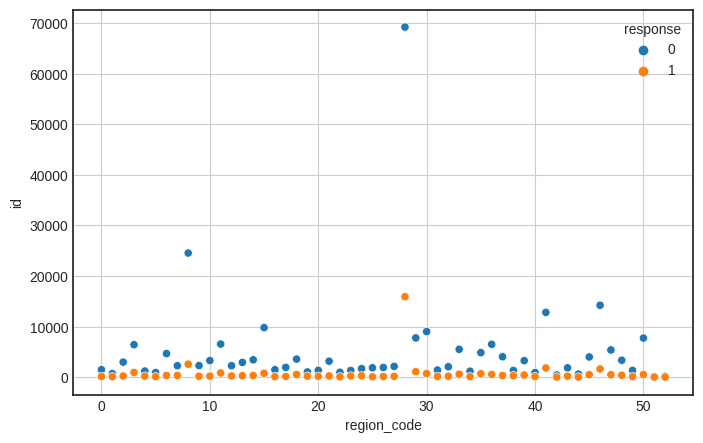

In [36]:
# region_code
aux = df1[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

plt.figure(figsize=(8,5))
sns.scatterplot(data=aux, x='region_code', y='id', hue='response')
plt.grid()

# region_code, aparentemente, não é capaz de explicar response

### 4.1.5. Previously Insured

In [37]:
# previously_insured
pd.crosstab(df1['previously_insured'], df1['response'], normalize='index')      # normalizar pelo index retorna o percentual da coluna sobre o total de cada linha

# previously_insured praticamente replica a variável resposta. Não é bom para treinar o modelo

response,0,1
previously_insured,,
0,0.774529,0.225471
1,0.999155,0.000845


### 4.1.6. Vehicle Age

In [38]:
# vehicle_age
df1[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,proportion
0,below_1_year,0,0.413475
1,below_1_year,1,0.018987
2,between_1_2_years,0,0.434181
3,between_1_2_years,1,0.091244
4,over_2_years,0,0.029782
5,over_2_years,1,0.012332


### 4.1.7. Policy Sales Channel

In [39]:
# policy_sales_channel

aux = pd.crosstab(df1['policy_sales_channel'], df1['response'], normalize='index')

<Axes: xlabel='policy_sales_channel'>

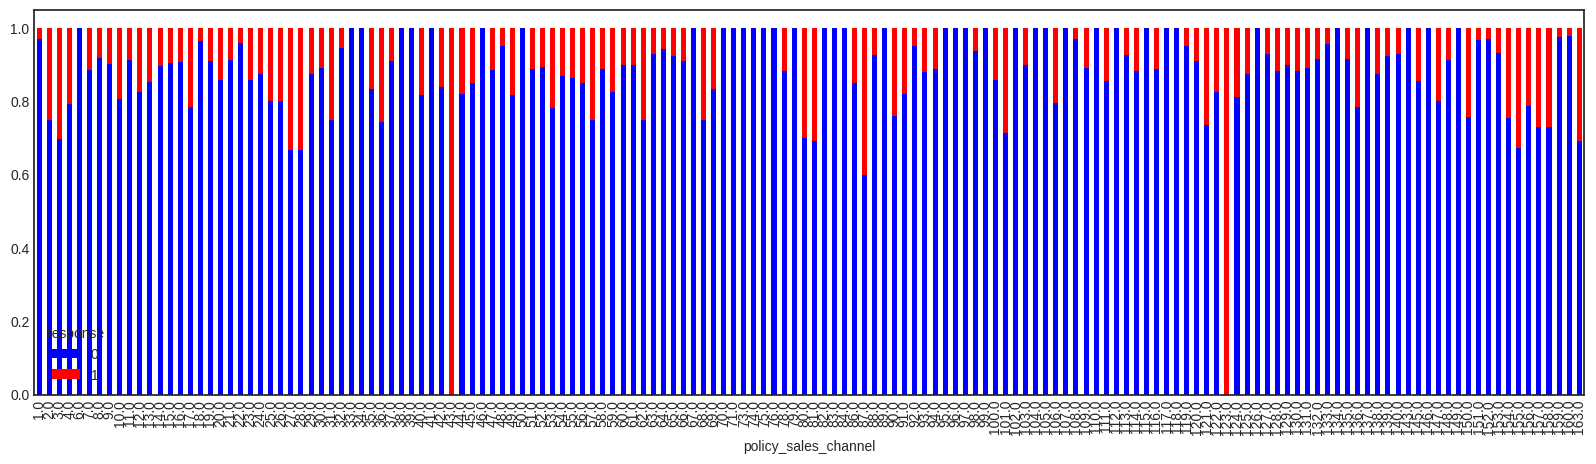

In [40]:
aux.plot(kind='bar', stacked=True, figsize=(20,5), colormap='bwr')

### 4.1.8. Vintage

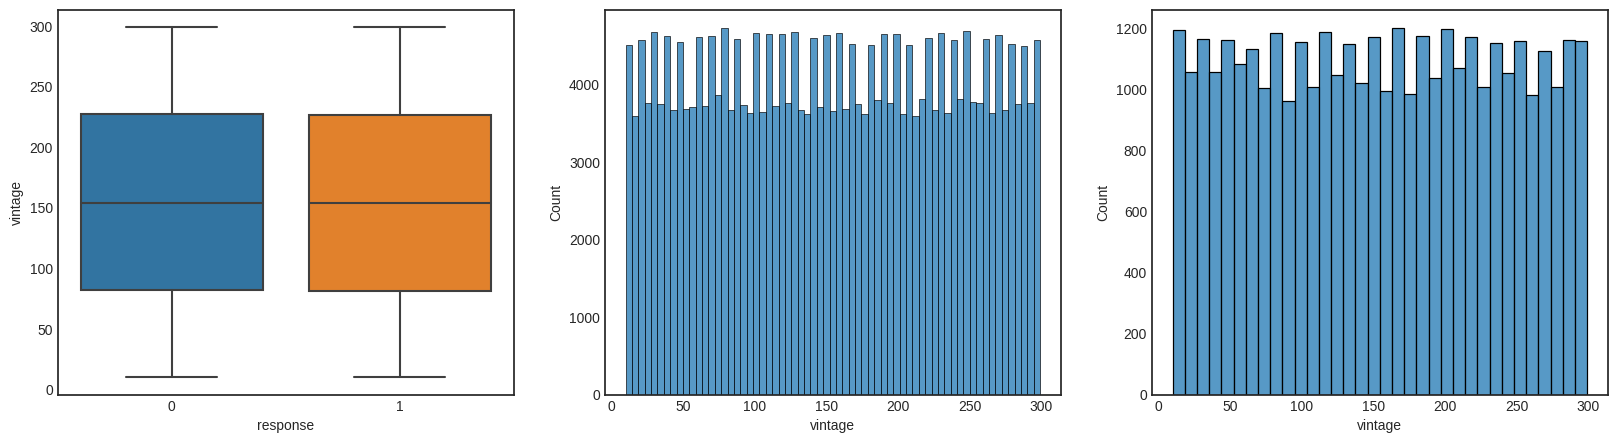

In [41]:
# vintage

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='vintage', data=df1)
sns.histplot(df1.loc[df1['response'] == 0, 'vintage'], ax=ax[1])
sns.histplot(df1.loc[df1['response'] == 1, 'vintage'], ax=ax[2]);

In [42]:
# gender

In [43]:
# vehicle_damage

## 4.3. Bivariate Analysis

In [44]:
cat_attributes['gender'].value_counts()
# Man: 54,08%
# Woman: 45,92%

gender
Male      164780
Female    140107
Name: count, dtype: int64

In [45]:
pd.DataFrame(cat_attributes.groupby('gender')['vehicle_age'].value_counts(sort=False))

count
gender vehicle_age       
Female 1-2 Year     62372
       < 1 Year     73123
       > 2 Years     4612
Male   1-2 Year     97823
       < 1 Year     58729
       > 2 Years     8228

In [46]:
pd.DataFrame(cat_attributes.groupby('vehicle_age')['gender'].value_counts(normalize=True, sort=False))

proportion
vehicle_age gender            
1-2 Year    Female    0.389350
            Male      0.610650
< 1 Year    Female    0.554584
            Male      0.445416
> 2 Years   Female    0.359190
            Male      0.640810

<Axes: xlabel='vehicle_age', ylabel='count'>

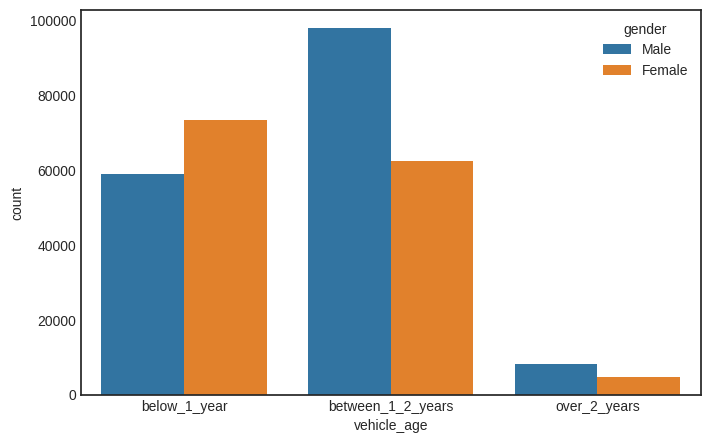

In [47]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x=df1['vehicle_age'], hue=df1['gender'])

In [48]:
# Number of women using cars are increasing. Cars wits < 1 year are mostly used by women

In [49]:
cat_attributes.groupby('gender')['vehicle_damage'].value_counts(sort=False)

gender  vehicle_damage
Female  No                76354
        Yes               63753
Male    No                74574
        Yes               90206
Name: count, dtype: int64

<Axes: xlabel='vehicle_damage', ylabel='count'>

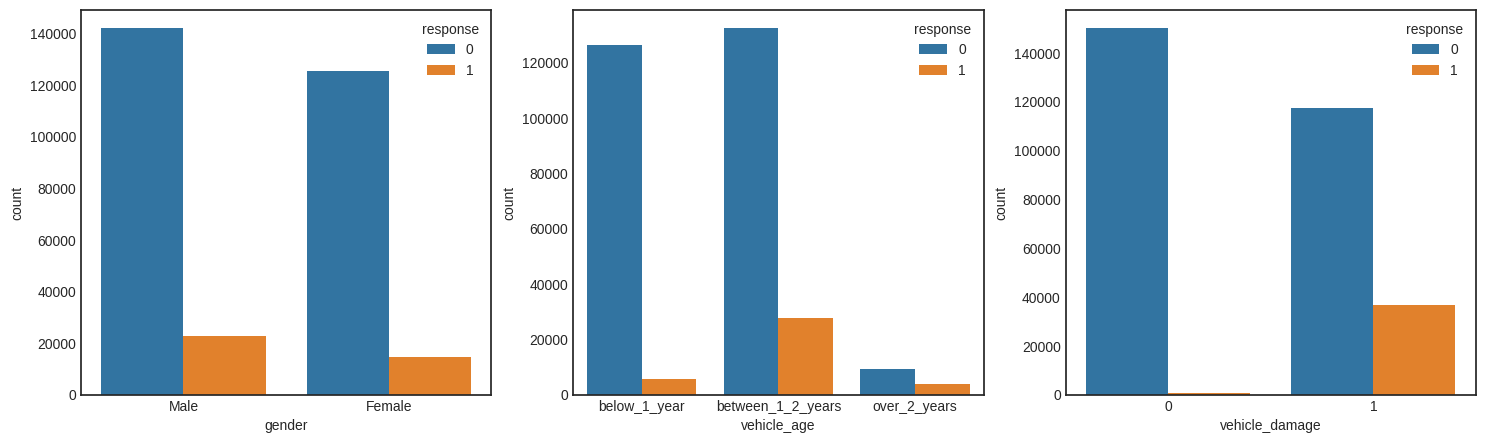

In [50]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.countplot(data=df1, x=df1['gender'], hue=df1['response'], ax=ax[0])
sns.countplot(data=df1, x=df1['vehicle_age'], hue=df1['response'], ax=ax[1])
sns.countplot(data=df1, x=df1['vehicle_damage'], hue=df1['response'], ax=ax[2])

# 5. Data Preparation

In [51]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40.0,0,below_1_year,1,25455.0,152.0,203,0
216539,216540,Female,26,1,8.0,1,below_1_year,0,38393.0,26.0,45,0
78983,78984,Female,32,1,28.0,0,below_1_year,1,32118.0,122.0,35,1
218368,218369,Male,32,1,37.0,0,below_1_year,1,37711.0,152.0,215,0
307215,307216,Female,24,1,28.0,0,below_1_year,1,48706.0,156.0,222,0


In [52]:
# Separando os dados entre treino (80%) e validação (20%)
df1_train, df1_val = train_test_split(df1, test_size=0.2, random_state=4, stratify=df1['response'])

X_val = df1_val.drop('response', axis=1)
y_val = df1_val['response']

save_interim(X_val, 'X_val.csv')
save_interim(y_val, 'y_val.csv')

In [53]:
df1_val.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
305498,305499,Male,60,1,29.0,1,between_1_2_years,0,42978.0,26.0,17,0
65866,65867,Male,45,1,46.0,1,between_1_2_years,1,23245.0,124.0,161,0
358671,358672,Female,24,1,28.0,1,below_1_year,0,65083.0,152.0,171,0
363590,363591,Female,36,1,41.0,0,between_1_2_years,1,29720.0,124.0,235,0
312157,312158,Male,60,1,43.0,0,between_1_2_years,1,40586.0,124.0,55,0


## 5.1. Standardization

- Ideal para dados que se aproximam de uma distribuição normal

In [54]:
# annual_premiuim
std_scaler = StandardScaler()

df1_train['annual_premium'] = std_scaler.fit_transform(df1_train[['annual_premium']])

In [55]:
pickle.dump(std_scaler, open('../models/annual_premium_feature.pkl', 'wb'))

## 5.2. Rescaling

- Quando os dados não apresentam distribuição normal

In [56]:
# age
mms_age = MinMaxScaler()
df1_train['age'] = mms_age.fit_transform(df1_train[['age']])

# vintage
mms_vintage = MinMaxScaler()
df1_train['vintage'] = mms_vintage.fit_transform(df1_train[['vintage']])

In [57]:
pickle.dump(mms_age, open('../models/age_feature.pkl', 'wb'))
pickle.dump(mms_vintage, open('../models/vintage_feature.pkl', 'wb'))

## 5.3. Encoder

In [58]:
# gender - target encoder
tar_enc_gender = TargetEncoder()
df1_train['gender'] = tar_enc_gender.fit_transform(df1_train[['gender']], df1_train['response'])

# region_code - target encoder
tar_enc_region_code = TargetEncoder()
df1_train['region_code'] = tar_enc_region_code.fit_transform(df1_train[['region_code']], df1_train['response'])

# vehicle_age - one hot encoder
ohe_vehicle_age = OneHotEncoder()
vehicle_age_encoded = ohe_vehicle_age.fit_transform(df1_train[['vehicle_age']])
vehicle_age_encoded = vehicle_age_encoded.toarray()
aux = pd.DataFrame(vehicle_age_encoded, columns=ohe_vehicle_age.get_feature_names_out(), index=df1_train.index)
df1_train = pd.concat([df1_train, aux], axis=1)
df1_train.drop('vehicle_age', axis=1, inplace=True)

# policy_sales_channel - frequency enconder
fe_policy_sales_channel = df1_train.groupby('policy_sales_channel').size() / len(df1_train)
df1_train.loc[:, 'policy_sales_channel'] = df1_train['policy_sales_channel'].map(fe_policy_sales_channel)

In [59]:
pickle.dump(tar_enc_gender, open('../models/gender_feature.pkl', 'wb'))
pickle.dump(tar_enc_region_code, open('../models/region_code_feature.pkl', 'wb'))
pickle.dump(ohe_vehicle_age, open('../models/vehicle_age_feature.pkl', 'wb'))
pickle.dump(fe_policy_sales_channel, open('../models/policy_sales_channel_feature.pkl', 'wb'))

In [60]:
save_interim(df1_train, 'train_df5.csv')

## 5.4. Validation Pipeline

In [61]:
# Fazer apenas transform

X_val['annual_premium'] = std_scaler.transform(X_val[['annual_premium']])

X_val['age'] = mms_age.transform(X_val[['age']])

X_val['vintage'] = mms_vintage.transform(X_val[['vintage']])

X_val['gender'] = tar_enc_gender.transform(X_val[['gender']])

X_val['region_code'] = tar_enc_region_code.transform(X_val[['region_code']])

X_val_vehicle_age_encoded = ohe_vehicle_age.transform(X_val[['vehicle_age']])
X_val_vehicle_age_encoded = X_val_vehicle_age_encoded.toarray()
aux = pd.DataFrame(X_val_vehicle_age_encoded, columns=ohe_vehicle_age.get_feature_names_out(), index=X_val.index)
X_val = pd.concat([X_val, aux], axis=1)
X_val.drop('vehicle_age', axis=1, inplace=True)

X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

In [62]:
X_val.isna().sum()

id                               0
gender                           0
age                              0
driving_license                  0
region_code                      0
previously_insured               0
vehicle_damage                   0
annual_premium                   0
policy_sales_channel             2
vintage                          0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_years    0
vehicle_age_over_2_years         0
dtype: int64

# 6. Feature Selection

<Axes: >

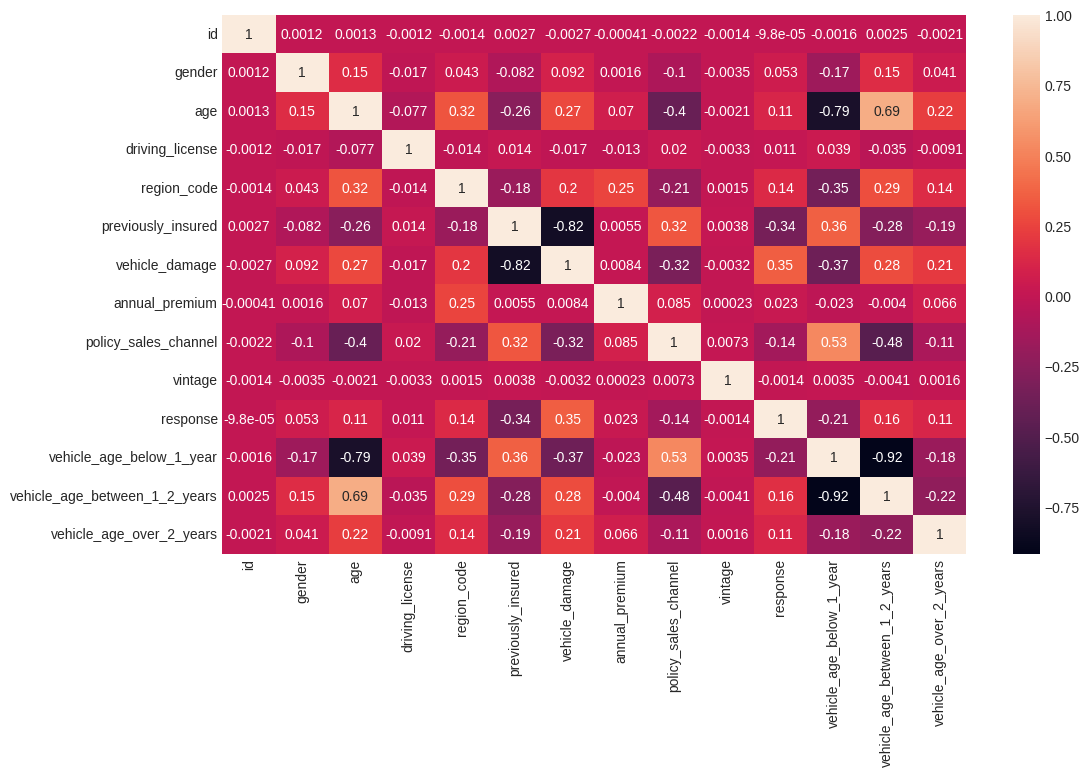

In [63]:
corr_matrix = df1_train.corr(method='pearson')

plt.figure(figsize=(12,7))
sns.heatmap(corr_matrix, annot=True)

## 6.1. Feature importance

- A partir de um modelo se busca encontrar as importâncias de cada feature para o dado modelo

In [64]:
# Treino do modelo
X_train_n = df1_train.drop(['id', 'response'], axis=1)
y_train_n = df1_train['response']

etree_clf = ExtraTreesClassifier(n_estimators=150, random_state=0, n_jobs=-1)
etree_clf.fit(X_train_n, y_train_n)

KeyboardInterrupt: 

In [ ]:
skplt.estimators.plot_feature_importances(etree_clf, feature_names=X_train_n.columns, figsize=(12,5), x_tick_rotation=60)

In [ ]:
np.sort(etree_clf.feature_importances_)[::-1]

## 6.2. Boruta

In [ ]:
#boruta_selector = BorutaPy(estimator=etree_clf, n_estimators='auto', verbose=2, random_state=42)
#boruta_selector.fit(X_train_n.values, y_train_n.values.ravel())

In [ ]:
#X_train_n.loc[:, boruta_selector.support_]

# 7. Machine Learing

In [ ]:
selected_features = ['vintage', 'annual_premium', 'region_code', 'age', 'gender', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# x_train = df1_train[selected_features]
# x_val = X_val[selected_features]

## 7.1. Teste com KNN

In [ ]:
# Definição e treino do modelo
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(df1_train[selected_features], df1_train[['response']])

# Predição - poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(X_val[selected_features])

In [ ]:
skplt.metrics.plot_cumulative_gain(y_true=y_val, y_probas=yhat_knn)
# Se 25% (Percentage of sample) das pessoas da lista ordenada forem abordadas, 63% (Gain) dos interessados serão aboradados
# Aumentando o n_neighbors, a curva pode melhorar

In [ ]:
fig, ax = plt.subplots()
skplt.metrics.plot_lift_curve(y_true=y_val, y_probas=yhat_knn, ax=ax)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 3)

## 7.2 Teste com Logistic Regression

In [ ]:
# Definição e treino do modelo
lr_model = LogisticRegression(random_state=42)
lr_model.fit(df1_train[selected_features], df1_train[['response']])

# Predição - poder de GENERALIZAÇÃO
yhat_lr = lr_model.predict_proba(X_val[selected_features])

In [ ]:
yhat_lr[:,1]

In [ ]:
pickle.dump(lr_model, open('/home/ezequiel/Documentos/Comunidade_DS/health_insurance_cross_sell/models/linear_regression_model.pkl', 'wb'))

In [ ]:
skplt.metrics.plot_cumulative_gain(y_true=y_val, y_probas=yhat_lr)
# Se 40% (Percentage of sample) das pessoas da lista ordenada forem abordadas, 90% (Gain) dos interessados serão aboradados

In [ ]:
fig, ax = plt.subplots()
skplt.metrics.plot_lift_curve(y_true=y_val, y_probas=yhat_lr, ax=ax)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 3)

## 7.3. Metrics at K

In [ ]:
# Propensity score
aux = pd.concat([X_val, y_val], axis=1)
aux['score'] = yhat_knn[:, 1].tolist()

# Sort clients by propensity score
aux = aux.sort_values('score', ascending=False)

aux = aux[['id', 'response', 'score']].reset_index(drop=True)

# K lines
K = 50

# Precision Top K
aux['precision_at_k'] = aux['response'].cumsum() / (aux.index.values + 1)
precision_at_k = aux.loc[K, 'precision_at_k']
print(f'Precision @ K: {precision_at_k:.6f}')

# Recall Top K
aux['recall_at_k'] = aux['response'].cumsum() / aux['response'].sum()
recall_at_k = aux.loc[K, 'recall_at_k']
print(f'Recall @ K: {recall_at_k:.6f}')